# ECE 47300 Assignment 10 Exercise

Your Name: Paloma Arellano

Objective: Build an RNN model to predict the next character in a sequence of text data from Shakespeare's plays.

# Exercise  1: Data Preprocessing (30 points)
In this part, you will implement some preprocessing functions.
Run the following code to load the text data from the given file "shakespeare.txt".

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import numpy as np
! pip install unidecode
import unidecode
import string
import time
import torch
import pdb

import torch.nn as nn
from torch.autograd import Variable
np.random.seed(123)

all_characters = string.printable
print(all_characters)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	



In [14]:
def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file

file = read_file("/content/drive/MyDrive/Colab Notebooks/ECE473/Assignment-10/shakespeare.txt")
file_len = len(file)
print(f"file length: {file_len}")
print(file[:100])

file length: 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


## Task 1: Implement function to get a random chunk of Shakespeare text
The `get_random_chunk` function is a helper function that generates a random chunk of **input text data** and **output text data** (which is one character shifted from the input) from the Shakespeare dataset. 
Specifically, the `chunk_len` argument specifies the size of the input and output sequences.
For example, if `chunk_len=4`, then a valid return value would be the two chunks:
`('Befo','efor')` or `('proc','roce')`.
This function is useful 
in generating diverse sets of input data for training the RNN model in the assignment.

Hints:
- Start from a random index of the file (but note that the max index must be small enough so that a full chunk can be extracted).
- Based on this random start index, extract `chunk_len` characters for the input sequence and `chunk_len` characters for the output sequence (shifted one character to the right).

In [15]:
def get_random_chunk(file, chunk_len = 100):
    ######### Your Code Here ###########
    rand_num = np.random.randint(0, len(file) - chunk_len)   
    return file[rand_num:(rand_num + chunk_len)], file[(rand_num + 1):(rand_num + chunk_len + 1)]
    ######### End of your code #########
    
curr_chunk, next_chunk = get_random_chunk(file='Hello world!', chunk_len=10)
#curr_chunk = "Hello worl"
#next_chunk = "ello world"
print(f"curr_chunk =>{curr_chunk}\n next_chunk=> {next_chunk}")

print(f"Is curr_chunk and next_chunk same length: {len(curr_chunk) == len(next_chunk)}")
print(f"Is next_chunk shifted by one: {curr_chunk[1:] == next_chunk[:-1]}")


curr_chunk =>Hello worl
 next_chunk=> ello world
Is curr_chunk and next_chunk same length: True
Is next_chunk shifted by one: True


### Task 2: Implement function to convert to tensors

Define a function `to_tensor(string)` that takes a string of characters as input and return torch tensor as output, similar to in the demo in class.
Specifically,
1. Create an empty tensor of shape `(len(string), 1, len(all_characters))` using the PyTorch `torch.zeros` function, 
    where `len(string)` is the length of the input string, 1 is the batch size, and `len(all_characters)` is the total 
    number of unique characters in the text data.
2. Loop through each character in the input string and convert it to a one-hot encoded vector.

In [16]:
def to_tensor(string):
######### Your Code Here ###########
    tensor = torch.zeros(len(string), 1, len(all_characters))
    for li, letter in enumerate(string): 
      found_letter = all_characters.find(letter)
      tensor[li][0][found_letter] = 1
    return tensor
######### End of your code #########

def get_one_hot_tensors(input, output):
    return to_tensor(input), to_tensor(output)
    
input, output = get_random_chunk(file, 50)
print(input.replace('\n', ' '))
print(output.replace('\n', ' '))
input_tensor, output_tensor = get_one_hot_tensors(input, output)
print(f"input shape: {input_tensor.shape}")
print(f"output shape: {output_tensor.shape}")

e, now scorn'd of me; For one being fear'd of all,
, now scorn'd of me; For one being fear'd of all, 
input shape: torch.Size([50, 1, 100])
output shape: torch.Size([50, 1, 100])


# Exercise  2: Build the RNN model (30 points)

In this part, you will build the RNN model using PyTorch.
- nn.GRU is used to implement the GRU algorithm for processing sequential input data.
    - https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
- The decoder layer is a fully connected neural network layer that maps the output of the GRU layer to the desired output size.
- As we are only implementing a single layer RNN, the model is not powerful enough to learn long-term dependencies in the text data. So don't be surprised if the output sentences are not very meaningful. We are providing you loss plots (`gru_loss_ex2.png`) to help you check if your code is working correctly.

In [17]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        # Define modules of RNN
        ######### Your Code Here ###########
        # Set `self.rnn_cell` to a nn.GRU
        self.rnn_cell = nn.GRU(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.n_layers)
        
        # Define a linear decoder layer that maps from the hidden size to the output size
        self.fc = nn.Linear(in_features=self.hidden_size, out_features=self.output_size)

        ######### End of your code #########
    
    def forward(self, input, hidden):
        ######### Your Code Here ###########
        # 1. Reshape the input to (1, 1, -1) and pass it to the GRU layer
        # 2. Reshape the rnn_cell output to (1, -1) and pass it to the decoder layer
        input = input.view(1, 1, -1)
        #print(input.size())
        output, hidden = self.rnn_cell(input, hidden)
        #print(output[0])
        output = self.fc(output[0])

        ######### End of your code #########
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [18]:
def train(inp, target, decoder):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    input_tensor, target_tensor = get_one_hot_tensors(inp, target)
    for c in range(len(inp)):
        output, hidden = decoder(input_tensor[c], hidden)
        loss += criterion(output, torch.argmax(target_tensor[c]).unsqueeze(0))

    loss.backward()
    decoder_optimizer.step() 
    return loss.item() / max_length

In [19]:
def evaluate(decoder, prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = to_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        out, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = to_tensor(predicted_char)

    return predicted

[(100 5.0%) 3.057278747558594]
Wh!inrem; s tans kor wenl lg pe t nmee cerwrony carens lenris tot rinakat hes, Ih, mintihe mors sd se  

[(200 10.0%) 2.5909051513671875]
Whe ruto ranl nord ansthe so a, for hander co tor to Vhet omas liman erou wasslo s our we tow,
Thave,  

[(300 15.0%) 2.155693359375]
Whis lice all'l' he the, ppithet the nou thespear, ionceld thy ceark hin trind onethe theve yout win h 

[(400 20.0%) 2.415105438232422]
Wher atem'd than pireroufemoy thar have
Whellle Fote,
Andsithe he ine!
Yourero forordder'st and in.

A 

[(500 25.0%) 1.9224430847167968]
Why us thtt and and shat not roy ur te me! she preser mand and wall rowis, froy ir spend hanl nourh th 

[(600 30.0%) 2.353057861328125]
Whace I I wike witly heas and me thanis as in wimad andithe and but at Shithin buthe that and the so,
 

[(700 35.0%) 2.254944305419922]
Whims al yak you wit him pucrent ad the pathe oupll, beast deen will ure hes wald for ma comes be thou 

[(800 40.0%) 2.0545606994628907]
Whad on th

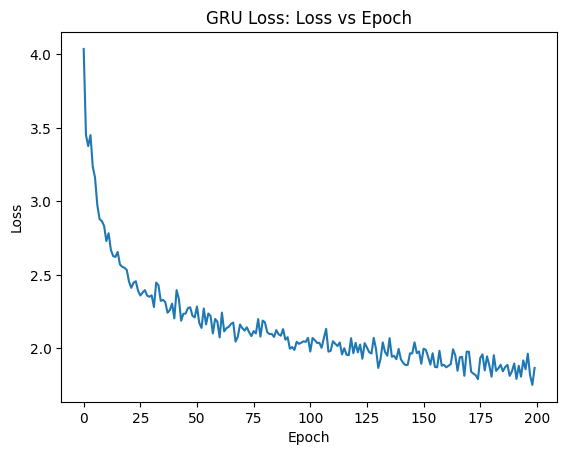

In [20]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005
max_length = len(all_characters)

decoder = RNN(max_length, hidden_size, max_length)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*get_random_chunk(file), decoder)       
    loss_avg += loss

    if epoch % print_every == 0:
        print(f"[({epoch} {epoch / n_epochs * 100}%) {loss}]")
        print(evaluate(decoder, 'Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

print(f"______________________________________________________________")
print(evaluate(decoder, 'Th', 200, temperature=0.2))

import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.title("GRU Loss: Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Exercise  3: Implement an LSTM model (40 points)

Using the equations from the slides in class, write your own LSTM cell module.
The code below will use this instead of the GRU cell module and train the model.

Notes:
- Note that for LSTM the hidden state is really both the $h_t$ and $C_t$ so we just unpack the passed hidden state into these two variables at the beginning, and pack them into a tuple for returning.
- We apply a single linear layer to compute all the linear parts of the model that operate on $h'_{t-1}$ and then unpack these using `chunk(4)` into the four separate parts. This is equivalent to having 4 separate linear layers.
- As we are only implementing a single layer RNN, the model is not powerful enough to learn long-term dependencies in the text data. So don't be surprised if the output sentences are not very meaningful. We are providing you loss plots (`lstm_loss_ex3.png`) to help you check if your code is working correctly.

In [23]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.xh = nn.Linear(input_size, hidden_size * 4, bias=bias)
        self.hh = nn.Linear(hidden_size, hidden_size * 4, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hidden=None):
        # Unpack hidden state and cell state
        hx, cx = hidden
        
        # Apply linear layers to input and hidden state
        linear = self.xh(input) + self.hh(hx)

        # Get outputs of applying a linear transform for each part of the LSTM
        input_linear, forget_linear, cell_linear, output_linear = linear.reshape(-1).chunk(4)

        ######### Your Code Here ###########
        # 1. Apply activation functions to get gates and new cell state information
        # 2. Calculate the new cell state (c_new)
        # 3. Calculate the new hidden state (h_new)
        ft = torch.sigmoid(forget_linear)   # forget gate
        it = torch.sigmoid(input_linear)    # input gate
        c_tilda = torch.tanh(cell_linear)   # new cell state information
        c_new = ft * cx + it * c_tilda      # update cell state

        ot = torch.sigmoid(output_linear)   # output gate
        h_new = ot * torch.tanh(c_new)

        ######### End of your code #########
        
        # Pack cell state $C_t$ and hidden state $h_t$ into a single hidden state tuple
        output = h_new # For LSTM the output is just the hidden state
        hidden = (h_new, c_new) # Packed h and C
        return output, hidden
      


[(100 5.0%) 3.6569949340820314]
Whjeow c-tl
a
i omlwownishan Hdt  oet 
tt
t r ahehshe wwud foe,lugohe ds,:    syeethtto Zef:oselihuh i 

[(200 10.0%) 3.151739501953125]
WhnSffvow  
s e ohfe  u an  
d rnh:hods  ees RemiLs leuhprd h ues T  .i e  ey  
tg :sotTlys eIy ihst,l 

[(300 15.0%) 3.2725210571289063]
Whthy , oye CriUt II rmeo r:teddos se rebatoetellt loeest t e i  eiseeh eh  eee gmlysnat e ae taabo h  

[(400 20.0%) 2.9442120361328126]
Whbu  elot lhytoa  ieur od ddt sei w  eo k at shwe io cslat stliotla v hao nn W
de ui noseher hod eone 

[(500 25.0%) 2.98296875]
WhO
co
nO ans erwe,  ydow ghoutwio se scoe den nre nta hed iisuthimao uba n lo t isp on t lodn  totn t 

[(600 30.0%) 2.6516888427734373]
Wh
aii wikcygy bir ththasr stirn, t hor ait sailic
ird 
ad  ire lhoc d rhigu ai po ln nufn


 herTh il 

[(700 35.0%) 2.5503564453125]
Wher non the las siut po, bin on  ek

eBog woe tis asre torreter tre tfetled ier fere ;o he hin gart e 

[(800 40.0%) 2.545997314453125]
Whe mo eu s tit

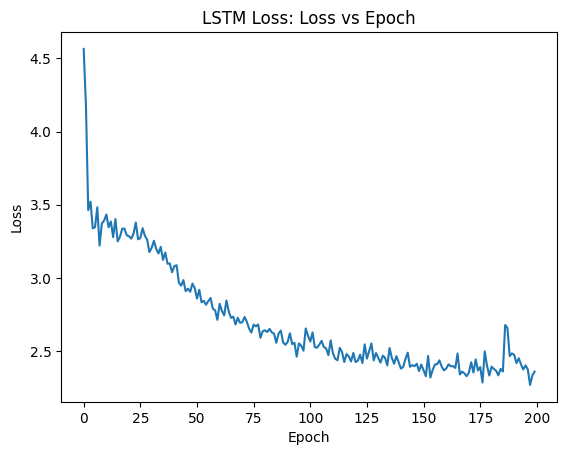

In [24]:
lr = 0.001
class LSTM_RNN(RNN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Replace the gru cell with LSTM cell
        self.rnn_cell = LSTMCell(max_length, hidden_size, max_length)
        
    def init_hidden(self):
        # LSTM cells need two hidden variables in a tuple of (h_t,C_t)
        return (Variable(torch.zeros(1, 1, self.hidden_size)), Variable(torch.zeros(1, 1, self.hidden_size)))
      
decoder = LSTM_RNN(max_length, hidden_size, max_length)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)

all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*get_random_chunk(file),decoder)       
    loss_avg += loss

    if epoch % print_every == 0:
        print(f"[({epoch} {epoch / n_epochs * 100}%) {loss}]")
        print(evaluate(decoder, 'Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

print(f"______________________________________________________________")
print(evaluate(decoder, 'Th', 200, temperature=0.2))

plt.plot(all_losses)
plt.title("LSTM Loss: Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# (Optional, ungraded) Exercise 4: Implement your own GRU

Same as above but implement a GRU instead of an LSTM module.